# Quantum Binary Classification with PennyLane + PyTorch (Breast Cancer)

This notebook trains a small **variational quantum classifier** on the Breast Cancer (Wisconsin) dataset using **PennyLane** and **PyTorch** only.

**Highlights**
- PCA to 4 components → 4-qubit circuit
- Clean PyTorch training loop (no TensorFlow/Keras)
- Final accuracy and confusion matrix + plots


**What you’ll learn here**
- How a *hybrid* quantum–classical model is built for binary classification.
- Why we scale + reduce data (MaxAbsScaler ➜ PCA) before sending it to a circuit.
- How the **ZZFeatureMap** encodes features and **TwoLocal** provides trainable expressivity.
- How we train with PyTorch and interpret metrics and plots.

### Pipeline at a glance
Data → scale to [0,1] → PCA(4) → 4‑qubit circuit (ZZFeatureMap + TwoLocal) → ⟨Z₀⟩ → probability → BCE loss.


## Setup

- We install **PennyLane** only. Colab already provides NumPy, PyTorch and scikit‑learn.
- We’ll keep everything in **float64** to match PennyLane’s default precision for stable gradients.


In [1]:
%pip -q install -U pennylane
import numpy as np
import torch
import pennylane as qml
print("PyTorch:", torch.__version__)
print("PennyLane:", qml.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.7 MB/s eta 0:00:00
PyTorch: 2.8.0+cu126
PennyLane: 0.43.0


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


## Reproducibility (seeds)

- Seeds are set for Python, NumPy and PyTorch to make runs repeatable.
- Full determinism on GPU can be slower; enabling it requires additional flags and may reduce performance.

In [20]:
import os, random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
print("Seeds set:", SEED)

Seeds set: 42


## Data: Breast Cancer (Wisconsin)

We load the dataset from scikit-learn, scale features, and reduce to **4 principal components** for a 4-qubit circuit.


**Dataset**: 569 samples × 30 features. Labels: 0 (malignant), 1 (benign).

**Why MaxAbsScaler + clip [0,1]?** Quantum rotations typically expect bounded inputs; clipping limits outliers and makes
angles more stable. MaxAbs scales each feature by its max absolute value **from the training set**.

**Why PCA(4)?** With 30 raw features, a naive encoding would need many qubits. Reducing to 4 components preserves most
variance while keeping a compact **4‑qubit** circuit.


In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

# Load
data = load_breast_cancer()
X = data.data.astype(np.float64)
y = data.target.astype(np.int64)  # 0/1

# Split: 80% train, 10% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

# Scale with MaxAbsScaler (fit on train), then clip to [0, 1]
scaler = MaxAbsScaler().fit(X_train)
x_tr = scaler.transform(X_train)
x_val = scaler.transform(X_val)
x_test = scaler.transform(X_test)

x_tr = np.clip(x_tr, 0.0, 1.0)
x_val = np.clip(x_val, 0.0, 1.0)
x_test = np.clip(x_test, 0.0, 1.0)

# PCA to 4 components (fit on train only)
pca = PCA(n_components=4).fit(x_tr)
Xs_tr = pca.transform(x_tr)
Xs_val = pca.transform(x_val)
Xs_te  = pca.transform(x_test)

print("Train/Val/Test shapes:", Xs_tr.shape, Xs_val.shape, Xs_te.shape)

Train/Val/Test shapes: (455, 4) (57, 4) (57, 4)


## Torch tensors & loaders

- We convert arrays to **torch.float64** and build batched DataLoaders.
- Batch size 20 is a practical default; smaller batches add more gradient noise, larger batches can slow each step.

In [22]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 20

Xtr_t = torch.from_numpy(Xs_tr).double()
ytr_t = torch.from_numpy(y_train.astype(np.float64)).double().reshape(-1, 1)
Xval_t = torch.from_numpy(Xs_val).double()
yval_t = torch.from_numpy(y_val.astype(np.float64)).double().reshape(-1, 1)
Xte_t  = torch.from_numpy(Xs_te).double()
yte_t  = torch.from_numpy(y_test.astype(np.float64)).double().reshape(-1, 1)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xval_t, yval_t), batch_size=batch_size, shuffle=False)

Xtr_t.shape, ytr_t.shape

(torch.Size([455, 4]), torch.Size([455, 1]))

## Quantum model (ZZFeatureMap + TwoLocal)

- Feature map: **ZZFeatureMap** (Hadamards + RZ for each feature, with pairwise entangling ZZ-style interactions).
- Ansatz: **TwoLocal** (reps of RY layers and linear CNOT chain, plus a final RY layer).

**ZZFeatureMap.** Each feature is loaded via Hadamard + RZ rotations and *pairwise* interactions using CZ–RZ–CZ blocks,
capturing 2‑body correlations.

**TwoLocal.** Alternating layers of single‑qubit `RY` rotations and a linear chain of `CNOT`s. `reps` controls depth:
higher depth → more expressive circuits but potentially harder optimization.

**Measurement.** We read ⟨Z⟩ on wire 0 (range −1…1) and map it to a probability with `(⟨Z⟩+1)/2`.


In [23]:
from itertools import combinations

n_qubits = 4
reps = 2  # depth for TwoLocal
dev = qml.device("default.qubit", wires=n_qubits)

def ZZFeatureMap(nqubits, data):
    nload = min(len(data), nqubits)
    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires=i)
    for q0, q1 in combinations(range(nload), 2):
        qml.CZ(wires=[q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) * (np.pi - data[q1]), wires=q1)
        qml.CZ(wires=[q0, q1])

def TwoLocal(nqubits, theta, reps=1):
    # theta is a flat vector of length (reps + 1) * nqubits
    for r in range(reps):
        for i in range(nqubits):
            qml.RY(theta[r * nqubits + i], wires=i)
        for i in range(nqubits - 1):
            qml.CNOT(wires=[i, i + 1])
    # final layer
    for i in range(nqubits):
        qml.RY(theta[reps * nqubits + i], wires=i)

@qml.qnode(dev, interface="torch", diff_method="best")
def qnode(x, theta):
    # x: (4,) torch tensor
    ZZFeatureMap(n_qubits, x)
    TwoLocal(n_qubits, theta, reps=reps)
    return qml.expval(qml.PauliZ(0))

### Batched QNode wrapper (PyTorch)

- This tiny `nn.Module` calls the QNode **per sample** and stacks outputs to shape `(batch, 1)`.
- We avoid shape heuristics and guarantee a scalar probability per example, which simplifies training.

In [24]:
import torch.nn as nn

class BatchedQNodeLayer(nn.Module):
    def __init__(self, qnode, weight_shapes):
        super().__init__()
        # ensure torch interface
        if getattr(qnode, "interface", None) not in ("torch",):
            qnode = qml.QNode(qnode.func, qnode.device, interface="torch", diff_method="best")
        self.qnode = qnode
        # register parameters
        self.params = nn.ParameterDict()
        for name, shape in weight_shapes.items():
            if isinstance(shape, int):
                shape = (shape,)
            elif isinstance(shape, (list, tuple)):
                shape = tuple(shape)
            else:
                raise ValueError(f"Invalid shape for {name}: {shape}")
            p = nn.Parameter(torch.randn(*shape, dtype=torch.float64) * 0.1)
            self.params[name] = p

    def forward(self, x):
        # x: (batch, 4) or (4,)
        x = x.to(dtype=torch.float64)
        if x.ndim == 1:
            x = x.unsqueeze(0)
        outs = []
        for i in range(x.shape[0]):
            ev = self.qnode(x[i], **{k: v for k, v in self.params.items()})
            if not isinstance(ev, torch.Tensor):
                ev = torch.tensor(ev, dtype=torch.float64)
            # map from [-1,1] to [0,1] probability
            p = (ev + 1.0) / 2.0
            outs.append(p.reshape(()))
        return torch.stack(outs, dim=0).unsqueeze(1)  # (batch, 1)

## Model

- The model is just the quantum layer; we already map ⟨Z⟩ to a probability inside the layer.
- If you want more capacity, expose multiple expectations (e.g., ⟨Z⟩ on several wires) and follow with a small
`nn.Linear(k, 1)` instead of averaging.

In [25]:
import torch.nn as nn
weight_shapes = {"theta": ((reps + 1) * n_qubits,)}  # flat vector for TwoLocal
model = nn.Sequential(BatchedQNodeLayer(qnode, weight_shapes)).double()
print(model)

Sequential(
  (0): BatchedQNodeLayer(
    (params): ParameterDict(  (theta): Parameter containing: [torch.DoubleTensor of size 12])
  )
)


## Training

- **Loss**: Binary Cross‑Entropy (BCE) between predicted probability and 0/1 labels.
- **Optimizer**: Adam with learning rate `5e-3`. If loss plateaus, try `1e-3` and/or increase `reps`.
- Monitor both training and validation loss to spot overfitting or underfitting.

In [26]:
epochs = 15
opt = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.BCELoss()

history = {"loss": [], "val_loss": []}

for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        opt.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        opt.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    print(f"Epoch {epoch:02d}/{epochs} - loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

Epoch 01/15 - loss: 0.6981 - val_loss: 0.6794
Epoch 02/15 - loss: 0.6580 - val_loss: 0.6498
Epoch 03/15 - loss: 0.6316 - val_loss: 0.6277
Epoch 04/15 - loss: 0.6116 - val_loss: 0.6144
Epoch 05/15 - loss: 0.6005 - val_loss: 0.6028
Epoch 06/15 - loss: 0.5907 - val_loss: 0.5947
Epoch 07/15 - loss: 0.5840 - val_loss: 0.5878
Epoch 08/15 - loss: 0.5768 - val_loss: 0.5806
Epoch 09/15 - loss: 0.5713 - val_loss: 0.5735
Epoch 10/15 - loss: 0.5652 - val_loss: 0.5698
Epoch 11/15 - loss: 0.5602 - val_loss: 0.5642
Epoch 12/15 - loss: 0.5560 - val_loss: 0.5598
Epoch 13/15 - loss: 0.5533 - val_loss: 0.5574
Epoch 14/15 - loss: 0.5507 - val_loss: 0.5558
Epoch 15/15 - loss: 0.5492 - val_loss: 0.5547


## Diagnostics: loss curves

- Healthy learning: training loss decreases; validation loss follows closely. Divergence suggests overfitting.
- If both flatten high, increase model capacity (`reps`) or train longer; if they diverge, regularize or reduce depth.

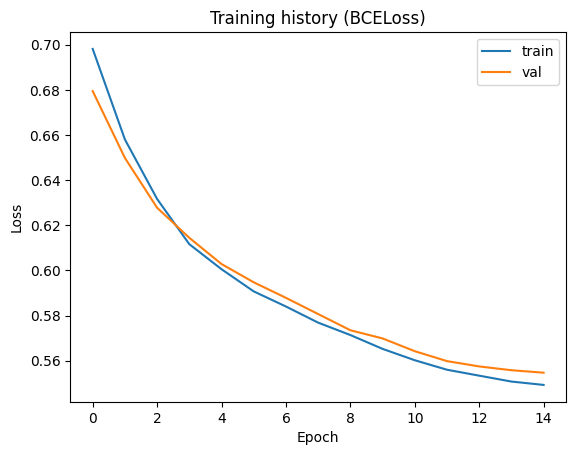

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training history (BCELoss)')
plt.legend()
plt.show()

## Final evaluation (accuracy + confusion matrix)

- **Accuracy** is the fraction of correct predictions at threshold 0.5.
- The **confusion matrix** summarizes TP/TN/FP/FN; for imbalanced data, consider AUC or F1 as well.


Test Accuracy: 0.7193
Confusion Matrix [ [TN FP], [FN TP] ]:
[[ 6 15]
 [ 1 35]]


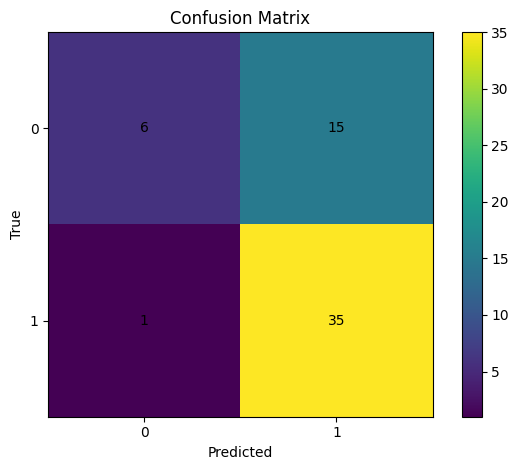

In [28]:
# Predict on test
with torch.no_grad():
    probs = model(Xte_t).squeeze().cpu().numpy()  # in [0,1]
preds = (probs >= 0.5).astype(np.int64)
ys = y_test

acc = float((preds == ys).mean())
print(f"Test Accuracy: {acc:.4f}")

# Confusion matrix (NumPy) + plot
def confusion_matrix_np(y_true, y_pred):
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    tp = int(((y_true==1) & (y_pred==1)).sum())
    return np.array([[tn, fp], [fn, tp]], dtype=int)

cm = confusion_matrix_np(ys, preds)
print("Confusion Matrix [ [TN FP], [FN TP] ]:")
print(cm)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0','1'])
plt.yticks(tick_marks, ['0','1'])
for i_ in range(2):
    for j_ in range(2):
        plt.text(j_, i_, cm[i_, j_], ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()